#### 经过处理,已经将大部分异常值从数据集中筛选出来了,接下来就是训练自己的模型了

In [1]:
# coding=utf-8
import numpy as np
from sklearn.datasets import load_files

def load_dataset(path):
    """加载数据的方法"""
    data = load_files(path)
    data_files = np.array(data['filenames'])
    data_targets = np.array(data['target'])
    return data_files, data_targets


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

def load_all_data(data_dir='train_set', test_size=0.2, random_state=np.random.randint(0, 10000)):
    """加载所有的处理过的猫狗数据"""
    train_files, train_targets = load_dataset(data_dir)
    X = train_files
    Y = train_targets
    x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return x_train, x_valid, y_train, y_valid


In [3]:
import matplotlib.pyplot as plt

def show_acc(history):
    """展示Accuracy数据"""
    print(history.history.keys())
    figure = plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accucary')
    plt.xlabel('accuracy')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train', 'valid'], loc='upper left')
    figure.savefig('performance_acc.png')

def show_loss(history):
    """展示Loss数据 """
    print(history.history.keys())
    figure = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Loss')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train', 'valid'], loc='upper left')
    figure.savefig('performance_loss.png')


In [4]:
#展示模型,因为要安装额外软件,所以linux就注释掉了
#from keras.utils import plot_model
#pip install pydot
#pip install pydot-ng
#pip install graphviz 
#参考https://blog.csdn.net/u011311291/article/details/80298563
#https://packages.ubuntu.com/search?keywords=graphviz&searchon=names
#plot_model(model, to_file='model.png',show_shapes=True)


In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# 另一种可视化模型的方法
def show_model(model):
    SVG(model_to_dot(model).create(prog='dot', format='svg'))


Using TensorFlow backend.


In [6]:
#接下来的处理方式是将所有的图片都处理成向量
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input as ir_preprocess_input
from tqdm import tqdm

# pip install  tqdm
# 注意要安装tqdm
def path_to_tensor(image_path, target_size=(299, 299)):
    '''将图片转换为tensor向量'''
    img = image.load_img(image_path, target_size=target_size)
    x = image.img_to_array(img)
    x = ir_preprocess_input(x)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(image_paths):
    '''批量将图片转换为tensor'''
    list_of_tensor = [path_to_tensor(image_path) for image_path in tqdm(image_paths)]
    return np.vstack(list_of_tensor)


In [7]:
from pandas import DataFrame

def predict_and_to_csv(test_dir, result_file, model):
    """按照图片顺序预测并输出结果到csv文件"""
    image_paths = load_image_paths(test_dir)
    result = predict_images(model, image_paths)
    dataframe = DataFrame(result)
    dataframe.index = np.arange(1, len(dataframe) + 1)
    dataframe.to_csv(result_file, index_label='id', header=['label'])
    return image_paths, result


In [8]:
# coding=utf-8
import numpy as np

# 写个方法加载验证集数据
def load_image_paths(path):
    '''输入相对路径,得到所有图片文件名'''
    paths = []
    for i in range(1, 12501):
        paths.append(path + str(i) + '.jpg')
    if len(paths) > 0:
        return np.array(paths)
    else:
        return None

def predict_images(model, file_names):
    '''根据名字输出是狗的概率'''
    x = paths_to_tensor(file_names)
    return model.predict(x)


In [9]:
from pandas import DataFrame

def array_to_csv(array):
    dataframe = DataFrame(array)
    dataframe.index = np.arange(1, len(dataframe) + 1)
    dataframe.to_csv('result.csv', index_label='id', header=['label'])


####  接下来,进行首次加载基准模型的尝试,并锁住基准模型中所有的层,添加新的层进行训练.
所做的操作有:
* 使用的整体数据的一小部分
* 加载好预训练好的InceptionResNetV2以及权重
* 在base_model的基础上增加Dense层和Dropout层
* 训练,将具有最佳val_acc时的模型权重保存起来

In [10]:
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D

base_model = InceptionResNetV2(weights='imagenet', include_top=False)
#将基准模型中的层全部锁住
for layer in base_model.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
# 添加一个分类器，我们有2个类
predictions = Dense(1, activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])
for i, layer in enumerate(model.layers):
    print(i, layer.name)

# 输出模型的样式
model.summary()

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

conv2d_72 (Conv2D)              (None, None, None, 6 27648       activation_71[0][0]              
__________________________________________________________________________________________________
batch_normalization_67 (BatchNo (None, None, None, 3 96          conv2d_67[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, None, None, 3 96          conv2d_69[0][0]                  
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, None, None, 6 192         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation_67 (Activation)      (None, None, None, 3 0           batch_normalization_67[0][0]     
__________________________________________________________________________________________________
activation

In [ ]:
from keras.callbacks import ModelCheckpoint
import os

# 开始训练模型
# 设置训练模型的epochs的数量
epochs = 15
batch_size=50
check_point_filepath='./saved_models/weights.best-{epoch:02d}-{val_acc:.5f}.hdf5'
saved_model_path='./saved_models'

#文件夹不存在,就创建文件夹
if not os.path.exists(saved_model_path):
    os.mkdir()
    
####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss',verbose=1, save_best_only=True)

#设置回调
call_back=[checkpointer]

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

In [ ]:
#开始训练
epochs=15
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=40,callbacks=call_back)

#### 在训练时遭遇了一个严重问题,在使用数据集5000,epoch=10,batch_size=50的时候,验证集的val_loss:保持在8.2847 ,val_acc:固定在0.4860,令人费解.
#### 我做了如下尝试:
* 1.停止训练,检查load_files,得到的数据,图片和target是一一对应的
* 2.减少了训练集大小和epoch和batch_size来加快训练速度
* 3.修改了model compile时使用的损失函数,从accuracy 改成binary_accuracy

#### 经过查找原因,发现是数据集太小,模型无法收敛了导致的
#### 解决方案:
* 使用云服务器,有aws和gcp等几个可以选择,我使用gcp继续进行模型的训练 

#### 在经过训练后,我又发现了上次类似的问题,验证集数据准确率只有0.51左右.最先考虑的情况是epoch太少,所以选择10-->30,发现作用不大
#### 问题原因:
* 数据集未经过预处理,且预处理的方法是InceptionResNet50独有的,这点需要注意


#### 经过训练.发现上面两图中的Loss在epoch=5的时候就到达了最大.Accurcy差不多是最高的,所以判断epoch<10内模型就应该收敛了,于是重新训练 并且将输入尺寸从224 * 224  改成模型默认的299 * 299

#### 在训练时,使用不同的batch_size,曲线有的变化很大,batch_size为40的时候,曲线比较平缓,在bacth_size分别为35,50,30的时候,学习曲线都上下震荡,所有就把40默认成训练时的batch_size

#### 在锁层并得到比较好的val_acc时,保存了权重,并加载这部分权重.然后尝试开放部分层来检测结果
所做过的尝试有:
* 只训练617-776层,在此之上的层锁住,得到的最终分数为0.22848
* 617以后的层都不锁, 训练.最终分数为0.16487``

#### 上面的方案尝试过后,决定修改策略.就是base_model直接锁层,只训练一次权重.
然后做过的尝试有:
* 只训练base_model的617-776层,最终分数是0.10634
*  260以后的层不锁,训练.最终分数是0.12924
* 全部不锁层,最终分数是:0.09176

####  开放更多层还是出现验证集Loss很低,但是测试集损失0.1左右,认为还是过拟合.
#### 猜测此模型可能容易发生过拟合.将采取下一个方案:
* 使用数据增强的方式

In [11]:
# 在此之前还要做一个重要的工作,就是提取bottleneck_feature
# ,这样就不用再训练模型的时候加载很久了
import os
import shutil

import h5py
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Lambda, Input, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

def rm_rf_and_mkdir(directory_name):
    """删除该目录下所有文件,如果不存在该文件夹,则新建
    :argument directory_name 要处理的文件夹
    """
    if os.path.exists(directory_name):
        shutil.rmtree(directory_name)
    os.mkdir(directory_name)


def save_bottleneck_feature(target_size=(299, 299), feature_file_name='inception_resnetv2.h5'):
    """获取特征向量
    :argument target_size 图片将被处理的尺寸
    :argument feature_file_name 特征向量存放的文件
    """
    if os.path.exists(feature_file_name):
        print('原文件已经存在,请先删除')
        return

    image_width = target_size[0]
    image_height = target_size[1]
    input_tensor = Input((image_width, image_height, 3))
    # 先使用该模型自带的预处理方法处理下
    processed_input = Lambda(preprocess_input)(input_tensor)

    base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=processed_input)
    #  将输入转输出,得到1536的输出,输出最后会被全局池化层处理下
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    generator = ImageDataGenerator()
    train_generator = generator.flow_from_directory('train_set', target_size, shuffle=False, batch_size=50)
    # 注意 class_mode为None
    test_generator = generator.flow_from_directory('test_set', target_size, shuffle=False, class_mode=None,
                                                   batch_size=50)
    # step_per_epoch是自动计算的
    train = model.predict_generator(train_generator, use_multiprocessing=True, verbose=1)
    test = model.predict_generator(test_generator, use_multiprocessing=True, verbose=1)

    with h5py.File(feature_file_name) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        # train_targets
        h.create_dataset("label", data=train_generator.classes)

In [ ]:
#  删除test_set文件夹,并为原目录创建软连接
# 不适用软连接,以免出现奇怪的问题
# rm_rf_and_mkdir('test_set')
# os.symlink('../test/', 'test_set/test')
# 保存特征向量
save_bottleneck_feature()

In [12]:
import h5py
import numpy as np
from sklearn.utils import shuffle

def get_train_data_target(feature_file_name='inception_resnetv2.h5'):
    """
    从h5文件中提取训练集数据,还有训练集标签
    """
    # 随机数放在这里,保证每次切分都一样
    np.random.seed(8282)
    with h5py.File(feature_file_name, 'r') as h:
        X_train = np.array(h['train'])
        y_train = np.array(h['label'])

    print(X_train.shape)
    X_train, y_train = shuffle(X_train, y_train)
    return X_train, y_train

def get_test_data(feature_file_name='inception_resnetv2.h5'):
    """
    从h5文件中提取测试集数据
    """
    with h5py.File(feature_file_name, 'r') as h:
        X_test = np.array(h['test'])

    print(X_test.shape)
    return X_test


In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import *
from keras.models import *

# 将得到的特征向量提取出来,并进行测试
def get_model(X_train,dropout=0.5,optimizer='adadelta'):
    """得到同一个模型,方便测试"""
    input_tensor = Input(X_train.shape[1:])
    x = Dropout(dropout)(input_tensor)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(input_tensor, x)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

(24951, 1536)
Train on 19960 samples, validate on 4991 samples
Epoch 1/20
19960/19960 [==============================] - 11s 538us/step - loss: 0.0802 - acc: 0.9807 - val_loss: 0.0210 - val_acc: 0.9954

Epoch 00001: val_loss improved from inf to 0.02097, saving model to ./saved_models/weights.best.06270059.valid-01-0.995392.hdf5
Epoch 2/20
19960/19960 [==============================] - 2s 124us/step - loss: 0.0252 - acc: 0.9943 - val_loss: 0.0165 - val_acc: 0.9954

Epoch 00002: val_loss improved from 0.02097 to 0.01648, saving model to ./saved_models/weights.best.06270059.valid-02-0.995392.hdf5
Epoch 3/20
19960/19960 [==============================] - 2s 122us/step - loss: 0.0206 - acc: 0.9948 - val_loss: 0.0137 - val_acc: 0.9958

Epoch 00003: val_loss improved from 0.01648 to 0.01368, saving model to ./saved_models/weights.best.06270059.valid-03-0.995792.hdf5
Epoch 4/20
19960/19960 [==============================] - 2s 121us/step - loss: 0.0206 - acc: 0.9948 - val_loss: 0.0135 - val_a

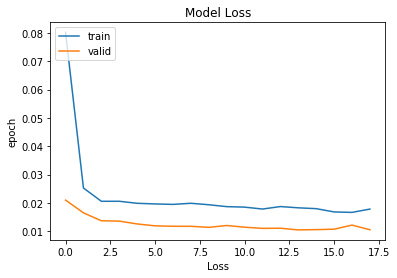

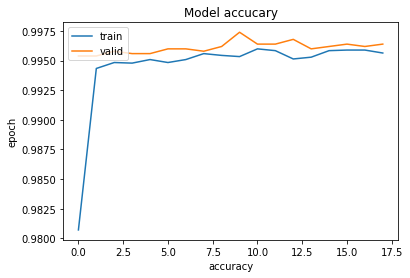

In [25]:
import os

# 获得模型,获得数据,进行迁移学习
X_train,y_train=get_train_data_target()
# 0.4->0.5
model=get_model(X_train,dropout=0.5)
# 增加停止点
early_stoping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
# 设置检查点
check_point_filepath = './saved_models/weights.best.06270059.valid-{epoch:02d}-{val_acc:.6f}.hdf5'

if not os.path.exists('saved_models'):
    os.mkdir('saved_models')
    
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True)
call_backs = [early_stoping, checkpointer]

# batch_size=40-->50
history = model.fit(X_train, y_train, batch_size=50, epochs=20, validation_split=0.2, callbacks=call_backs)

show_loss(history)
show_acc(history)

In [14]:
def predict_and_to_csv_with_clip(test_dir, result_file, model, clip=True):
    """按照图片顺序预测并输出结果到csv文件"""
    image_paths = load_image_paths(test_dir)
    result = predict_images(model, image_paths)
    dataframe = DataFrame(result.clip(min=0.005, max=0.995))
    dataframe.index = np.arange(1, len(dataframe) + 1)
    dataframe.to_csv(result_file, index_label='id', header=['label'])
    return image_paths, result


In [15]:
def predict_and_to_csv_sperately(test_dir,result_file_witho_type,model,clip=True):
    """按照图片顺序预测并输出结果到csv文件"""
    image_paths=load_image_paths(test_dir)
    result=predict_images(model,image_paths)
    dataframe=DataFrame(result.clip(min=0.005, max=0.995))
    dataframe.index = np.arange(1, len(dataframe)+1)
    dataframe.to_csv(result_file_witho_type+'.csv',index_label ='id',header=['label'])
    dataframe2=DataFrame(result)
    dataframe2.index = np.arange(1, len(dataframe2)+1)
    dataframe2.to_csv(result_file_witho_type+'without_cliped.csv',index_label ='id',header=['label'])
    return image_paths,result

####  我的策略
1.先提取特征
2.使用数据增强
3.锁住一部分层
4.开始训练

从上图来看,模型在epoch=15的时候,获得了最好的结果.训练的结果是最好的.为了验证这个解决,我测试在epoch=15和epoch=18(结束时)时的预测结果的成绩

In [28]:
X_test = get_test_data()
# 在epoch=18时的预测结果
predict_of_epoch18 = model.predict(X_test, verbose=1)

# 然后加载epoch=15时的权重,再预测
model.load_weights('./saved_models/weights.best.06270059.valid-14-0.995993.hdf5')
predict_of_epoch15 = model.predict(X_test, verbose=1)


(12500, 1536)
12500/12500 [==============================] - 1s 105us/step


In [16]:
from keras.preprocessing.image import *

def get_sorted_prediction(prediction, clip=True, show_head=True):
    """将预测结果按照正常顺序排列
    :argument clip True就clip结果,限制在[0.05,0.995],False不做修改
    :argument prediction 预测的结果
    :argument show_head 展示部分结果
    """
    if clip:
        prediction = prediction.clip(min=0.005, max=0.995)
    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory('test_set', shuffle=False, class_mode=None, batch_size=50)

    # 创建数组来保存正常的预测结果
    array = np.zeros(len(test_generator.filenames))
    for i, file_name in enumerate(test_generator.filenames):
        index = int(file_name[file_name.rfind('/') + 1:file_name.rfind('.')])
        # 因为prediction得到的n * 1维的数组
        array[index - 1] = prediction[i][0]
    if show_head:
        print('prediction:', prediction[0:10])
        print(test_generator.filenames[0:10])
        print(array[0:10])
    return array


In [17]:
from pandas import DataFrame

def predict_to_csv(result_file, prediction):
    """#预测并输出结果到csv文件"""
    dataframe = DataFrame(prediction)
    dataframe.index = np.arange(1, len(dataframe) + 1)
    dataframe.to_csv(result_file, index_label='id', header=['label'])
    print(dataframe[:10])


In [33]:
# 预测结果,查看模型权重下的预测成绩
prediction_18= get_sorted_prediction(predict_of_epoch18, False, False)
predict_to_csv('20180627_epoch_18prediction.csv', prediction_18)

prediction_15 = get_sorted_prediction(predict_of_epoch15, False, False)
predict_to_csv('20180627_epoch_15prediction.csv', prediction_15)

Found 12500 images belonging to 1 classes.
               0
1   9.999516e-01
2   9.995267e-01
3   9.994354e-01
4   9.998715e-01
5   1.837755e-09
6   5.427155e-06
7   1.468096e-08
8   2.170155e-07
9   2.016937e-07
10  2.888063e-09
Found 12500 images belonging to 1 classes.
               0
1   9.999224e-01
2   9.993688e-01
3   9.992649e-01
4   9.998184e-01
5   2.922480e-09
6   5.405547e-06
7   1.905002e-08
8   2.931197e-07
9   2.420207e-07
10  4.140370e-09


In [ ]:
# 成绩分别是 0.05452 0.05365

In [34]:
# 然后比较下做了clip后的预测成绩
prediction_18= get_sorted_prediction(predict_of_epoch18, True, False)
predict_to_csv('20180627_epoch_18prediction_cliped.csv', prediction_18)

prediction_15 = get_sorted_prediction(predict_of_epoch15, True, False)
predict_to_csv('20180627_epoch_15prediction_cliped.csv', prediction_15)

Found 12500 images belonging to 1 classes.
        0
1   0.995
2   0.995
3   0.995
4   0.995
5   0.005
6   0.005
7   0.005
8   0.005
9   0.005
10  0.005
Found 12500 images belonging to 1 classes.
        0
1   0.995
2   0.995
3   0.995
4   0.995
5   0.005
6   0.005
7   0.005
8   0.005
9   0.005
10  0.005


In [ ]:
# 成绩分别是0.03935 0.03902 

如果不对结果做Clip操作,名次还是不够高的.所以接下来选择微调

#### 接下来的方案是选择微调

In [18]:
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adadelta
import numpy as np

# 之前训练得到的权重
top_model_weights_path = './saved_models/weights.best.06270059.valid-14-0.995993.hdf5'

# 使用InceptionResNetV2作为base_model
final_model = InceptionResNetV2(weights='imagenet', include_top=False)
# 将基准模型617层前的全部锁住
for layer in final_model.layers[:617]:
    layer.trainable = False

# 构建下面的几层
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=final_model.output_shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
# 前面几层模型需要加载之前训练好的权重
top_model.load_weights(top_model_weights_path)
print('top_model.load_weights')

print('final_model inited')
# 两个模型拼接在一起就是我们自己的模型啦
# final_model.add(top_model)

model2 = Sequential()
model2.add(final_model)
model2.add(top_model)
model2.summary()
# 构建我们需要训练的完整模型
# model = Model(inputs=base_model.input, outputs=predictions)
# final_model.add(top_model)

print('model2 outshape', model2.output_shape)
model2.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# 输出模型的样式
model2.summary()

gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.5,
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True)

# 也要更新下样本啊
x_train, x_valid, y_train, y_valid = load_all_data(test_size=0.2, random_state=np.random.randint(0, 10000))

# 加载数据
x_train_data = paths_to_tensor(x_train)
x_valid_data = paths_to_tensor(x_valid)

# 增加停止点
early_stoping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
# 设置检查点
check_point_filepath = './saved_models/weights.final_model.06272213.valid-{epoch:02d}-{val_acc:.6f}.hdf5'
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stoping, checkpointer]

# 使用数据增强
train_genetrator = gen.flow(x_train_data, y_train, batch_size=50, shuffle=True)
valid_genetrator = gen.flow(x_valid_data, y_valid, batch_size=50, shuffle=True)
history = model2.fit_generator(train_genetrator, epochs=30, verbose=1, callbacks=callbacks,
                               validation_data=valid_genetrator)


top_model.load_weights
final_model inited
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
model2 outshape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
________________________________

100%|██████████| 4991/4991 [00:27<00:00, 180.72it/s]


Epoch 1/30
400/400 [==============================] - 438s 1s/step - loss: 0.1076 - acc: 0.9592 - val_loss: 0.5816 - val_acc: 0.9012

Epoch 00001: val_loss improved from inf to 0.58164, saving model to ./saved_models/weights.final_model.06272213.valid-01-0.901222.hdf5
Epoch 2/30
400/400 [==============================] - 419s 1s/step - loss: 0.0633 - acc: 0.9761 - val_loss: 0.0946 - val_acc: 0.9669

Epoch 00002: val_loss improved from 0.58164 to 0.09455, saving model to ./saved_models/weights.final_model.06272213.valid-02-0.966940.hdf5
Epoch 3/30
400/400 [==============================] - 413s 1s/step - loss: 0.0508 - acc: 0.9819 - val_loss: 0.0734 - val_acc: 0.9754

Epoch 00003: val_loss improved from 0.09455 to 0.07336, saving model to ./saved_models/weights.final_model.06272213.valid-03-0.975356.hdf5
Epoch 4/30
400/400 [==============================] - 415s 1s/step - loss: 0.0434 - acc: 0.9838 - val_loss: 0.0648 - val_acc: 0.9792

Epoch 00004: val_loss improved from 0.07336 to 0.06

dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])
dict_keys(['acc', 'val_loss', 'loss', 'val_acc'])


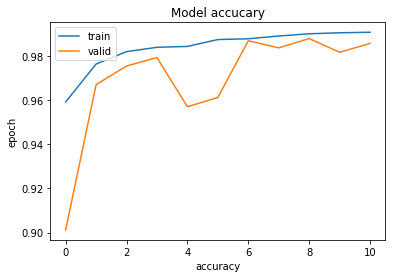

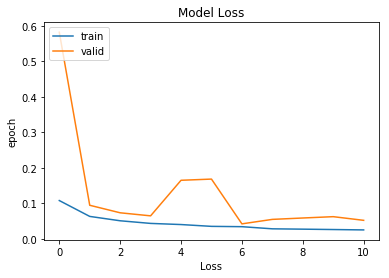

In [19]:
show_acc(history)
show_loss(history)

In [21]:
# 在模型结束训练时,预测结果
paths, array = predict_and_to_csv_with_clip('./test_set/test/', 'result06282322_fine_tune.csv',model2)

100%|██████████| 12500/12500 [01:12<00:00, 172.04it/s]


In [18]:
# 定义一个方法,能将测试集合训练集从原有的训练集中随机分开到不同的文件夹中
import numpy as np
import os
from sklearn.model_selection import train_test_split


def create_flow_dir():
    """将测试集合验证集分别创建软连接"""
    X_train,X_valid,y_train,y_valid=load_all_data()
    train_set2='train_set2'
    valid_set2='valid_set2'
    train_set_dog_dir='train_set2/dog/'
    train_set_cat_dir='train_set2/cat/'
    valid_set_dog_dir='valid_set2/dog/'
    valid_set_cat_dir='valid_set2/cat/'
    rm_rf_and_mkdir(train_set2)
    rm_rf_and_mkdir(valid_set2)
    os.mkdir(train_set_dog_dir)
    os.mkdir(train_set_cat_dir)
    os.mkdir(valid_set_dog_dir)
    os.mkdir(valid_set_cat_dir)


    train_dog_files=[x[x.rfind('/')+1 : ] for x in X_train if 'dog' in x]
    valid_dog_files=[x[x.rfind('/')+1 : ] for x in X_valid if 'dog' in x]
    train_cat_files=[x[x.rfind('/')+1 : ] for x in X_train if 'cat' in x]
    valid_cat_files=[x[x.rfind('/')+1 : ] for x in X_valid if 'cat' in x]

    for file_name in train_cat_files:
        os.symlink('../../train_set/cat/'+file_name,'train_set2/cat/'+file_name,)

    for file_name in valid_cat_files:
        os.symlink('../../train_set/cat/'+file_name,'valid_set2/cat/'+file_name,)
    
    for file_name in train_dog_files:
        os.symlink('../../train_set/dog/'+file_name,'train_set2/dog/'+file_name)
    
    for file_name in valid_dog_files:
        os.symlink('../../train_set/dog/'+file_name,'valid_set2/dog/'+file_name)
        

In [34]:
# 将测试集和验证集分开
create_flow_dir()

In [22]:
# 使用模型的最佳权重来预测结果 
model2.load_weights('./saved_models/weights.final_model.06272213.valid-07-0.986776.hdf5')
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result06282321_fine_tune_best.csv',model2)

100%|██████████| 12500/12500 [01:09<00:00, 178.65it/s]


In [ ]:
# 对预测结果经过Clip操作后,最好的模型和最后的模型的成绩分别是0.03878 0.04159 

In [42]:
# 保存模型,optimizer 为adadelta
model_file_name_for_aladelta='dog_0627_2239_fine_tune_adadelta.h5'
model2.save(model_file_name_for_aladelta)

In [ ]:
# 上一次的SGD 1E-4学习速率,batch_size=40,速度较慢,现在使用更大的学习速率和batch_size

In [35]:
from keras import Model
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.optimizers import SGD,Adadelta
import sys

# 之前训练得到的权重
top_model_weights_path='./saved_models/weights.best.06270059.valid-14-0.995993.hdf5'

# 使用InceptionResNetV2作为base_model
final_model = InceptionResNetV2(weights='imagenet', include_top=False)
# 将基准模型617层前的全部锁住
for layer in final_model.layers[:617]:
    layer.trainable = False

# 构建下面的几层
top_model = Sequential()
top_model.add(GlobalAveragePooling2D(input_shape=final_model.output_shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
# 前面几层模型需要加载之前训练好的权重
top_model.load_weights(top_model_weights_path)
print('top_model.load_weights')
    
model2 = Sequential()
model2.add(final_model)
model2.add(top_model)
model2.summary()
# 构建我们需要训练的完整模型
# model = Model(inputs=base_model.input, outputs=predictions)
# final_model.add(top_model)

print('model2 outshape',model2.output_shape)
model2.compile(loss='binary_crossentropy', optimizer=SGD(lr=5e-4, momentum=0.9), metrics=['accuracy'])

# 输出模型的样式
model2.summary()

gen=ImageDataGenerator(rotation_range=30, width_shift_range=0.1,height_shift_range=0.1,shear_range=0.5,
                zoom_range=0.2,horizontal_flip=True,vertical_flip=True,preprocessing_function=preprocess_input)


# 增加停止点
early_stoping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
# 设置检查点
check_point_filepath = './saved_models/weights.final_model.06270059.valid-{epoch:02d}-{val_acc:.6f}.hdf5'
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks = [early_stoping, checkpointer]


train_genetrator=gen.flow_from_directory('train_set2',batch_size=50,shuffle=True,
                                         class_mode='binary',target_size=(299,299))
valid_genetrator=gen.flow_from_directory('valid_set2',batch_size=50,shuffle=True,
                                         class_mode='binary',target_size=(299,299))
history=model2.fit_generator(train_genetrator,epochs=20,verbose=1,callbacks=callbacks,
                    validation_data=valid_genetrator)


top_model.load_weights
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
model2 outshape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
___________________________________________________

  0%|          | 0/12500 [00:00<?, ?it/s]

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


100%|██████████| 12500/12500 [01:09<00:00, 179.52it/s]


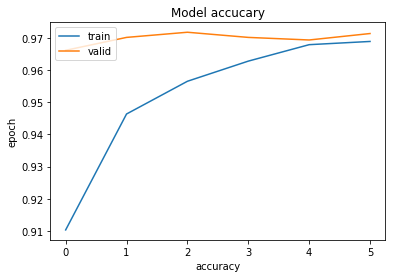

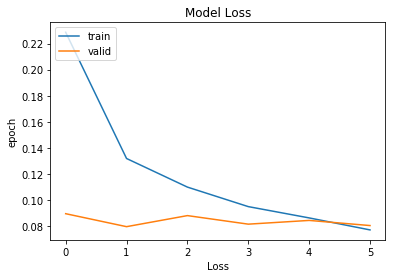

In [41]:
show_acc(history)
show_loss(history)
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result00701_1553',model2)

In [23]:
# 使用模型的最佳权重来预测结果 
model2.load_weights('./saved_models/weights.final_model.06270059.valid-02-0.970146.hdf5')
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result0701_1553_fine_tune_best.csv',model2)


 44%|████▍     | 5507/12500 [00:30<00:38, 181.09it/s]


 88%|████████▊ | 10957/12500 [01:00<00:08, 180.55it/s]


100%|██████████| 12500/12500 [01:09<00:00, 180.64it/s]

In [24]:
# 准备保存模型,表现比fine-tune还差
model_file_name='dog_0628_0152_sgd5e4.h5'
model2.save(model_file_name)

In [19]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import time


def train_model(dropout_rate=0.5, optimizer='adadelta', batch_size=50, layer_index_until_unlocked=617,
                top_model_weights_path='./saved_models/weights.best.06270059.valid-14-0.995993.hdf5',
                image_generator=ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
                                                   shear_range=0.5,
                                                   zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                                   preprocessing_function=preprocess_input)):
    """现在使用不同的创建模型时,选择不同的参数"""
    # 之前训练得到的权重
    top_model_weights_path = top_model_weights_path

    time_str = time.strftime("%Y-%m-%d %H:%M %p", time.localtime())
    check_point_path = './saved_models/weights.fine_tune_' + time_str \
                       + 'drop_out_' + str(dropout_rate) \
                       + 'batch_size_' + str(batch_size) \
                       + 'valid - {epoch: 02d} - {val_acc: .6f}.hdf5'
    # 使用InceptionResNetV2作为base_model
    base_model = InceptionResNetV2(weights='imagenet', include_top=False)
    # 将基准模型617层前的全部锁住
    for layer in base_model.layers[:layer_index_until_unlocked]:
        layer.trainable = False
    print('base_model load finished')

    # 构建下面的几层
    top_model = Sequential()
    top_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
    top_model.add(Dropout(dropout_rate))
    top_model.add(Dense(1, activation='sigmoid'))
    # 前面几层模型需要加载之前训练好的权重
    top_model.load_weights(top_model_weights_path)
    print('top_model load finished')

    final_model = Sequential()
    final_model.add(base_model)
    final_model.add(top_model)
    final_model.summary()
    print('final_model output_shape', final_model.output_shape)

    final_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # 输出模型的样式
    final_model.summary()

    # 增加停止点
    early_stoping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
    # 设置检查点
    check_point_path = check_point_path
    checkpointer = ModelCheckpoint(filepath=check_point_path, monitor='val_loss', verbose=1, save_best_only=True)
    callbacks = [early_stoping, checkpointer]

    train_genetrator = image_generator.flow_from_directory('train_set2', batch_size=batch_size, shuffle=True,
                                                           class_mode='binary', target_size=(299, 299))
    valid_genetrator = image_generator.flow_from_directory('valid_set2', batch_size=batch_size, shuffle=True,
                                                           class_mode='binary', target_size=(299, 299))

    history = final_model.fit_generator(train_genetrator, epochs=20, verbose=1, callbacks=callbacks,
                                        validation_data=valid_genetrator)

    return history, final_model


In [19]:
from keras.optimizers import SGD,Adadelta

# 之前训练得到的权重,加上adadelta lr=0.5 进行学习
history,model=train_model(optimizer=Adadelta(lr=0.5))

top_model.load_weights
final_model inited
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
model2 outshape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
________________________________


 26%|██▌       | 5216/19960 [00:30<01:25, 171.47it/s]


 52%|█████▏    | 10366/19960 [01:00<00:56, 170.41it/s]


 77%|███████▋  | 15431/19960 [01:30<00:26, 169.82it/s]


  8%|▊         | 406/4991 [00:02<00:25, 177.36it/s]


100%|██████████| 4991/4991 [00:27<00:00, 180.27it/s]

Epoch 1/30
400/400 [==============================] - 443s 1s/step - loss: 0.1030 - acc: 0.9622 - val_loss: 0.0881 - val_acc: 0.9738

Epoch 00001: val_loss improved from inf to 0.08809, saving model to ./saved_models/weights.final_model.06231637.valid-01-0.973753.hdf5
Epoch 2/30
400/400 [==============================] - 408s 1s/step - loss: 0.0552 - acc: 0.9793 - val_loss: 0.1015 - val_acc: 0.9719

Epoch 00002: val_loss did not improve from 0.08809
Epoch 3/30
400/400 [==============================] - 409s 1s/step - loss: 0.0466 - acc: 0.9841 - val_loss: 0.0492 - val_acc: 0.9842

Epoch 00003: val_loss improved from 0.08809 to 0.04920, saving model to ./saved_models/weights.final_model.06231637.valid-03-0.984172.hdf5
Epoch 4/30
400/400 [==============================] - 408s 1s/step - loss: 0.0397 - acc: 0.9860 - val_loss: 0.0750 - val_acc: 0.9766

Epoch 00004: val_loss did not improve from 0.04920
Epoch 5/30
400/400 [==============================] - 409s 1s/step - loss: 0.0341 - acc:

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])
dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


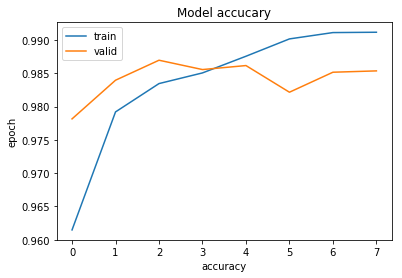

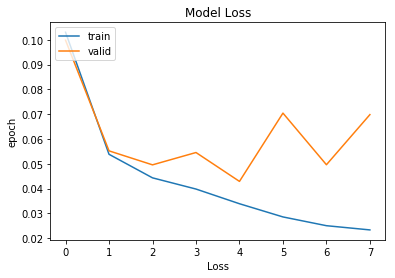

In [49]:
show_acc(history)
show_loss(history)

In [50]:
# 使用模型的最后权重来预测结果 
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-01 17:21_fine_tune_last.csv',final_model)
# 7/1 adadelta lr=0.5 batch_size=50 选择的最后权重,有Clp操作 0.4751 
# 7/1 adadelta lr=0.5 batch_size=50 最后权重 没有clip操作 0.14492

100%|██████████| 12500/12500 [01:10<00:00, 176.82it/s]


In [52]:
# 使用模型的最佳权重来预测结果 ,adadelta lr=0.5
final_model.load_weights('./saved_models/weights.final_model.06231637.valid-09-0.987978.hdf5')
paths, result = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-01 17:21_fine_tune_best.csv',final_model)
# 7/1日下午 adadelta lr=0.5 有Clip操作,batch_size=40.选择最佳权重 0.3958
# 7/1 adadelta lr=0.5 最佳权重,没有Clip操作 batch_size=50 0.13460

100%|██████████| 12500/12500 [01:09<00:00, 179.97it/s]


In [20]:
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input as ir_preprocess_input
import numpy as np

def load_final_model(model_file_name):
    """加载训练好的模型和对应的权重"""
    model = load_model(model_file_name)
    return model

def predict_single_file(image_path, model):
    """预测单张照片的概率"""
    tensor = path_to_tensor(image_path)
    result = model.predict(np.vstack(tensor))
    return result[0]


In [21]:

% matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random
# 批量显示图片的方法,每行显示4张
def plot_gallery(image_paths, n_col=4, random_size=None):
    """Helper function to plot a gallery of portraits
    :argument image_paths 所有图片的路径
    :argument random_size 是否从中随机抽取几张图片
    :argument n_col 每行显示的图片
    """
    if random_size:
        image_paths = random.sample(image_paths, random_size)

    n_row = len(image_paths) / n_col + 1
    plt.figure(figsize=(4 * n_col, 4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(len(image_paths)):
        plt.subplot(n_row, n_col, i + 1)
        picture = mpimg.imread(image_paths[i])
        plt.imshow(picture, cmap=plt.cm.gray)
        plt.title(image_paths[i], size=14)
        plt.xticks(())
        plt.yticks(())

    plt.show()

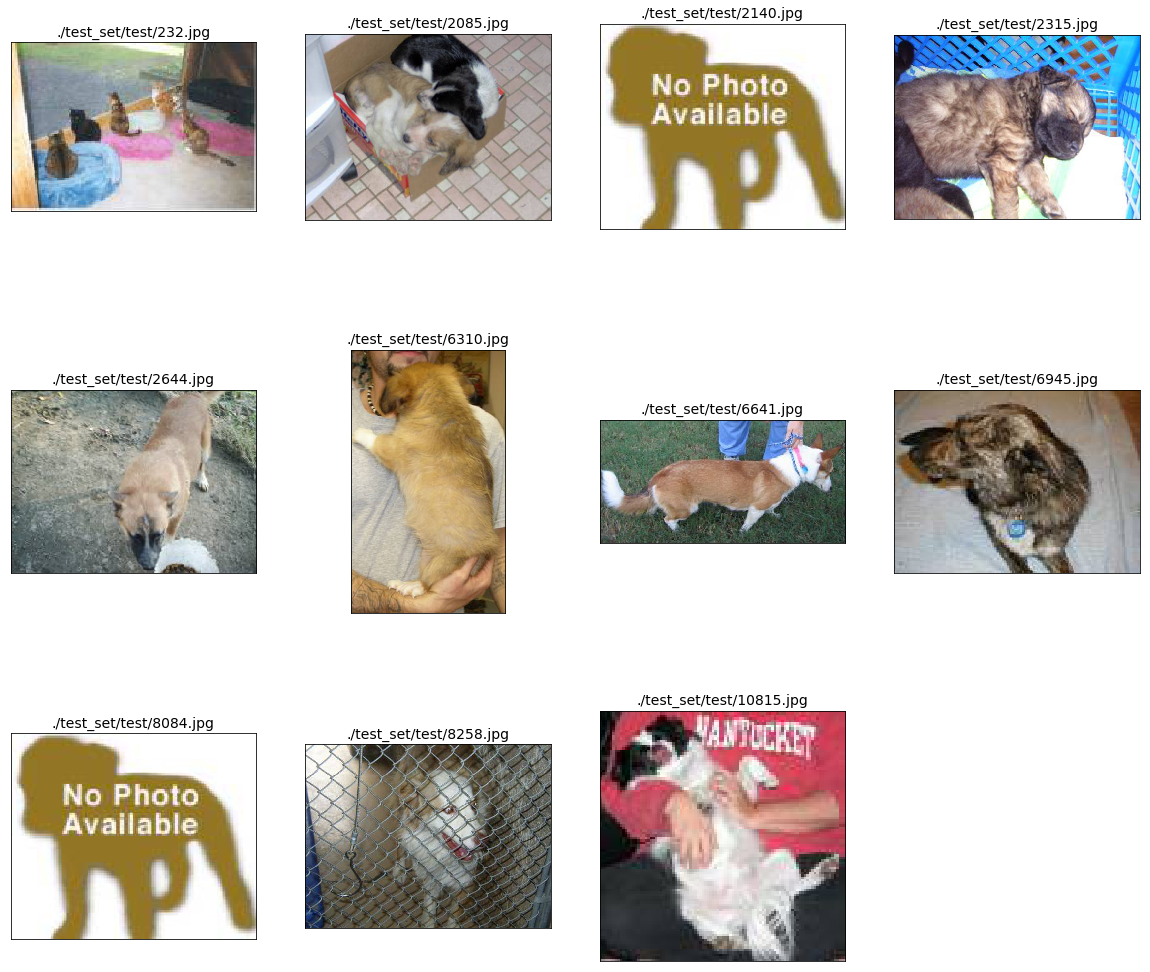

In [70]:
# 找出识别概率为0.4-0.6之前的图片的路径
# paths, result = predict_and_to_csv_sperately('./test_set/test/', 'test_set_result',model)
paths_of_images=paths[np.where((result >= 0.4) & (result <= 0.6))[0]]
# 看这些图片有什么共同点
plot_gallery(paths_of_images)

In [22]:
from keras.optimizers import SGD,Adadelta

# 之前训练得到的权重,加上SGD lr=5e-4 进行学习
history,model=train_model(optimizer=SGD(lr=5e-4))

base_model load finished
top_model load finished
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
final_model output_shape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


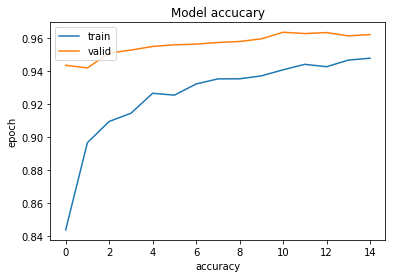

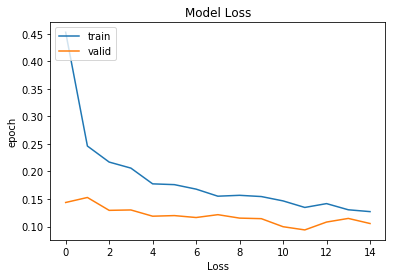

In [23]:
# SGD lr=5e-4 batch_size=50
show_acc(history)
show_loss(history)

In [25]:
# 使用模型的最后权重来预测结果  SGD lr=5e-4 batch_size=50
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-01 2319_fine_tune_last.csv',model)
# 7/1 SGD lr=5e-4 batch_size=50 选择的最后权重,有Clp操作  0.04098
# 7/1 SGD lr=5e-4 batch_size=50  最后权重 没有clip操作  0.05029

100%|██████████| 12500/12500 [01:16<00:00, 163.98it/s]


In [27]:
# 使用模型的最佳权重来预测结果 ,SGD lr=5e-4 batch_size=50
model.load_weights('./saved_models/weights.fine_tune_2018-07-01 21:00 PMdrop_out_0.5batch_size_50valid -  12 -  0.962533.hdf5')
paths, result = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-01  2319__fine_tune_best.csv',model)
#  7/1 SGD lr=5e-4 batch_size=50  选择最佳权重 有Clip操作 0.04084
# 7/1  SGD lr=5e-4 batch_size=50  选择最佳权重,没有Clip操作 0.04955

100%|██████████| 12500/12500 [01:09<00:00, 178.80it/s]


In [28]:
# 保存模型
model.save('2018-07-01_21_00_drop_out_0.5_batch_size_50_sgd.h5')

In [29]:
from keras.optimizers import SGD,Adadelta

# 之前训练得到的权重,加上默认的adadelta进行学习
history,model=train_model()

base_model load finished
top_model load finished
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
final_model output_shape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


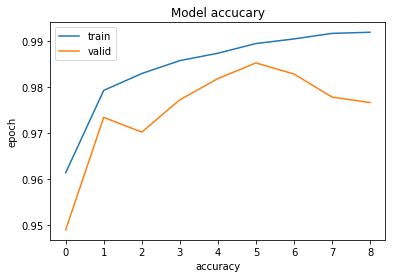

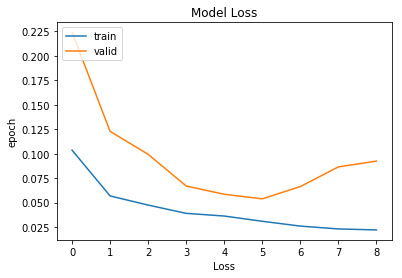

In [34]:
show_acc(history)
show_loss(history)

In [30]:
# 使用模型的最后权重来预测结果  Adadelta 默认参数 batch_size=50
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-02 0116_fine_tune_last.csv',model)
# 7/1  Adadelta 默认参数 batch_size=50 选择的最后权重,有Cilp操作  0.05607
# 7/1  Adadelta 默认参数 batch_size=50 最后权重 没有clip操作 0.12477

100%|██████████| 12500/12500 [01:09<00:00, 180.46it/s]


In [31]:
# 使用模型的最佳权重来预测结果 ,Adadelta 默认参数 batch_size=50
model.load_weights('./saved_models/weights.fine_tune_2018-07-01 23:50 PMdrop_out_0.5batch_size_50valid -  6 -  0.985173.hdf5')
paths, result = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-02 0116_fine_tune_best.csv',model)
#  7/1 Adadelta 默认参数 batch_size=50  选择最佳权重 有Clip操作 0.04226
# 7/1  Adadelta 默认参数 batch_size=50  选择最佳权重,没有Clip操作 0.08997

100%|██████████| 12500/12500 [01:08<00:00, 181.38it/s]


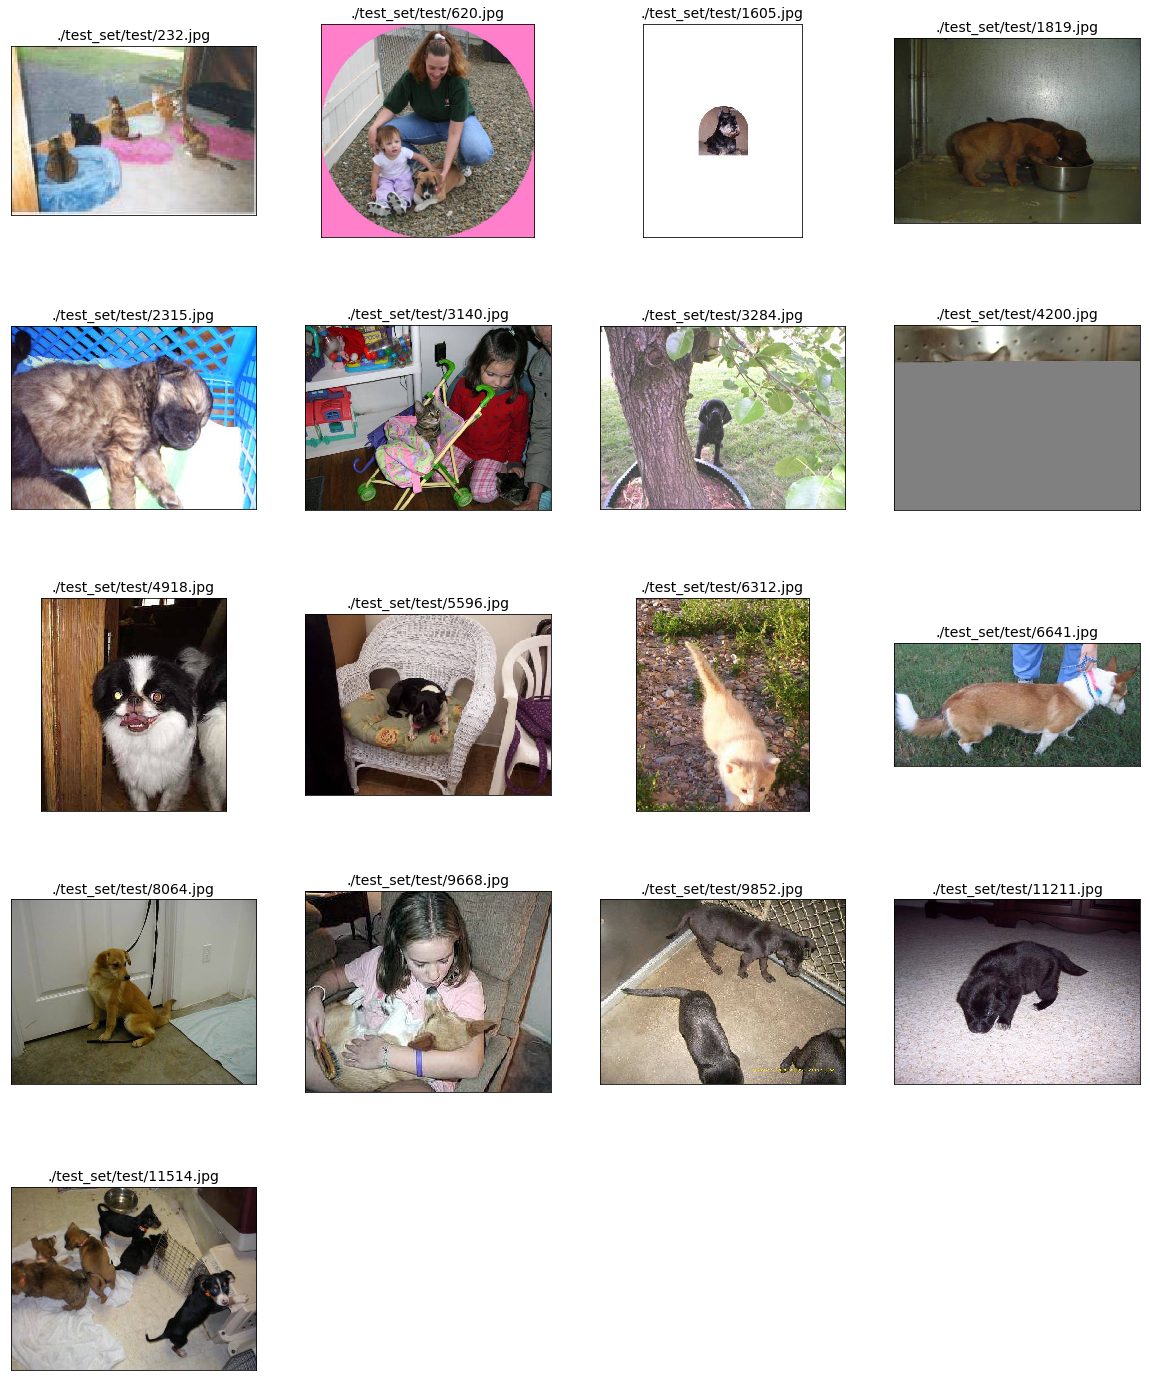

In [35]:
# 找出识别概率为0.4-0.6之前的图片的路径
# paths, result = predict_and_to_csv_sperately('./test_set/test/', 'test_set_result',model)
paths_of_images=paths[np.where((result >= 0.4) & (result <= 0.6))[0]]
# 看这些图片有什么共同点
plot_gallery(paths_of_images)

In [22]:
from keras.optimizers import SGD,Adadelta
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.optimizers import SGD

image_generator=ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
                                                   shear_range=0.5,
                                                   zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                                   preprocessing_function=preprocess_input)
optimizer=SGD(lr=5e-4)
# 之前训练得到的权重,加上默认的adadelta进行学习
history,model=train_model(optimizer=optimizer,image_generator=image_generator)

base_model load finished
top_model load finished
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
_________________________________________________________________
final_model output_shape (None, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, None, None, 1536)  54336736  
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 1537      
Total params: 54,338,273
Trainable params: 23,543,553
Non-trainable params: 30,794,720
________________

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


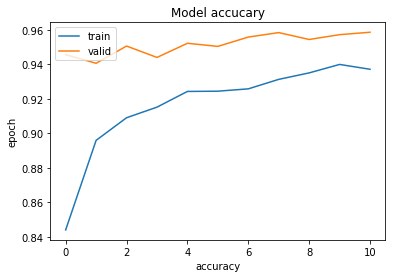

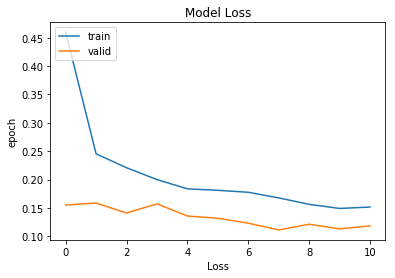

In [23]:
show_acc(history)
show_loss(history)

In [24]:
# 使用模型的最后权重来预测结果  SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator
paths, array = predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-02 2131_fine_tune_last.csv',model)
# 7/2    SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator  选择的最后权重,有Cilp操作  0.04040
# 7/2    SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator 最后权重 没有clip操作 0.04883

100%|██████████| 12500/12500 [01:18<00:00, 160.19it/s]


In [25]:
# 使用模型的最佳权重来预测结果  SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator
model.load_weights('./saved_models/weights.fine_tune_2018-07-02 19:47 PMdrop_out_0.5batch_size_50valid -  8 -  0.958525.hdf5')
paths,results=predict_and_to_csv_sperately('./test_set/test/', 'result_2018-07-02 2131_fine_tune_best.csv',model)
# 7/2    SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator  选择最佳权重,有Cilp操作  0.04073
# 7/2    SGD lr=5e-4 batch_size=50  更加激进的ImageGenerator 选择最佳权重 没有clip操作 0.04827

100%|██████████| 12500/12500 [01:10<00:00, 178.28it/s]


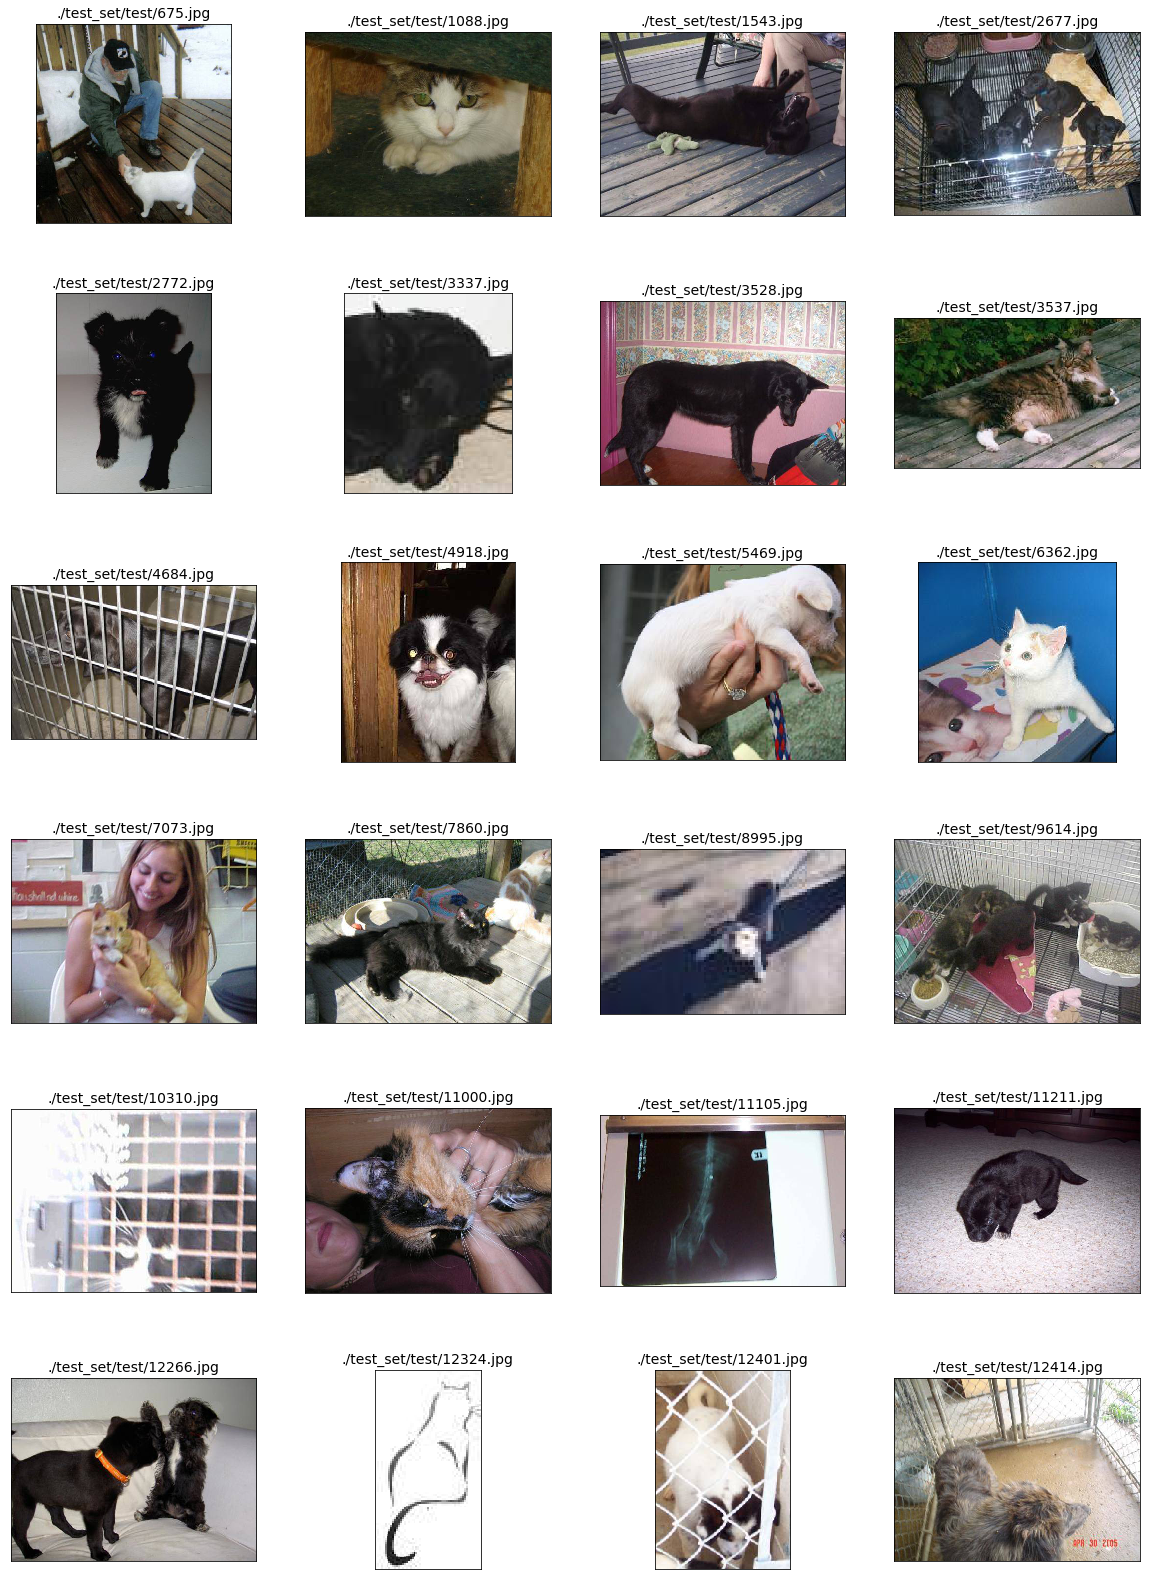

In [26]:
# 找出识别概率为0.4-0.6之前的图片的路径
# paths, result = predict_and_to_csv_sperately('./test_set/test/', 'test_set_result',model)
paths_of_images=paths[np.where((results >= 0.4) & (results <= 0.6))[0]]
# 看这些图片有什么共同点
plot_gallery(paths_of_images)

In [27]:
model.save('final_model_with_sgd5e_4.h5')